In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries



In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (MultiHeadAttention, LayerNormalization, Concatenate, Lambda)
from tensorflow.keras.applications import EfficientNetB0
import tensorflow.keras.backend as K
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import pandas as pd


In [ ]:
train_path = "/content/drive/MyDrive/FER/cnn/train"
test_path = "/content/drive/MyDrive/FER/cnn/test"

## Data Preprocessing

In [ ]:
target_classes = ['angry', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
def load_images_from_folders(folder_path, target_classes, max_images_per_class=2000, image_size=(48, 48)):
    images, labels = [], []
    for class_name in target_classes:
        class_folder = os.path.join(folder_path, class_name)
        image_files = sorted(os.listdir(class_folder))[:max_images_per_class]

        for file in image_files:
            img_path = os.path.join(class_folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(class_name)

    return np.array(images), np.array(labels)


This function loads and resizes a specified number of images per class from subfolders, assigns class labels to them, and returns the images and labels as NumPy arrays for further processing.

In [ ]:
def load_images_from_folders_test(folder_path, target_classes, max_images_per_class=400, image_size=(48, 48)):
    images, labels = [], []
    for class_name in target_classes:
        class_folder = os.path.join(folder_path, class_name)
        image_files = sorted(os.listdir(class_folder))[:max_images_per_class]

        for file in image_files:
            img_path = os.path.join(class_folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(class_name)

    return np.array(images), np.array(labels)


This function loads and resizes a specified number of test images per class from subfolders, assigns class labels, and returns the images and labels as NumPy arrays for evaluation or testing.

In [ ]:
X_train, y_train = load_images_from_folders(train_path, target_classes)
X_test, y_test = load_images_from_folders_test(test_path, target_classes)

print("Total images loaded:", X_train.shape[0])
print("Image shape:", X_train.shape[1:])
print("Total labels loaded:", len(y_train))
print("Unique class counts:", {cls: list(y_train).count(cls) for cls in target_classes})


Total images loaded: 10000
Image shape: (48, 48, 3)
Total labels loaded: 10000
Unique class counts: {'angry': 2000, 'happy': 2000, 'neutral': 2000, 'sad': 2000, 'surprise': 2000}


This code loads the training and test images along with their labels from the respective directories, prints the total number of training images, the shape of each image, the total number of labels, and counts the number of images per class in the training dataset to give an overview of the data distribution.

In [ ]:
y_test.shape

(2000,)

## Data Visualizations

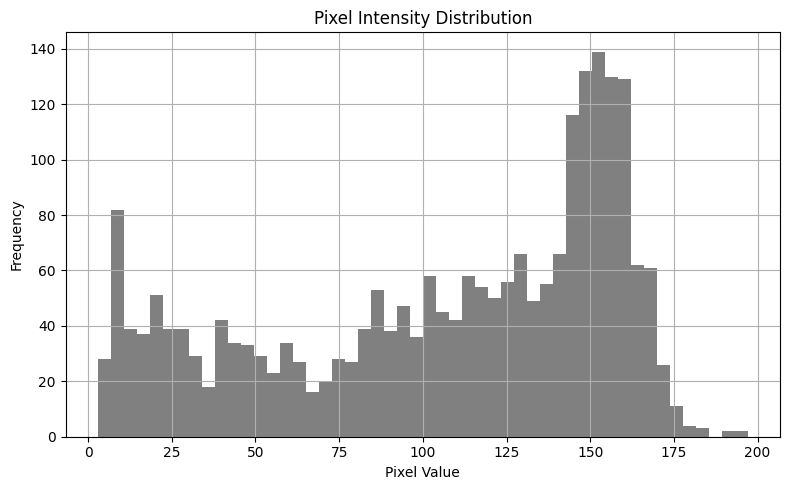

In [ ]:
sample_img_path = os.path.join(
    train_path,
    sorted(os.listdir(train_path))[0],
    sorted(os.listdir(os.path.join(train_path, sorted(os.listdir(train_path))[0])))[0])
img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)


plt.figure(figsize=(8, 5))
plt.hist(img.ravel(), bins=50, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


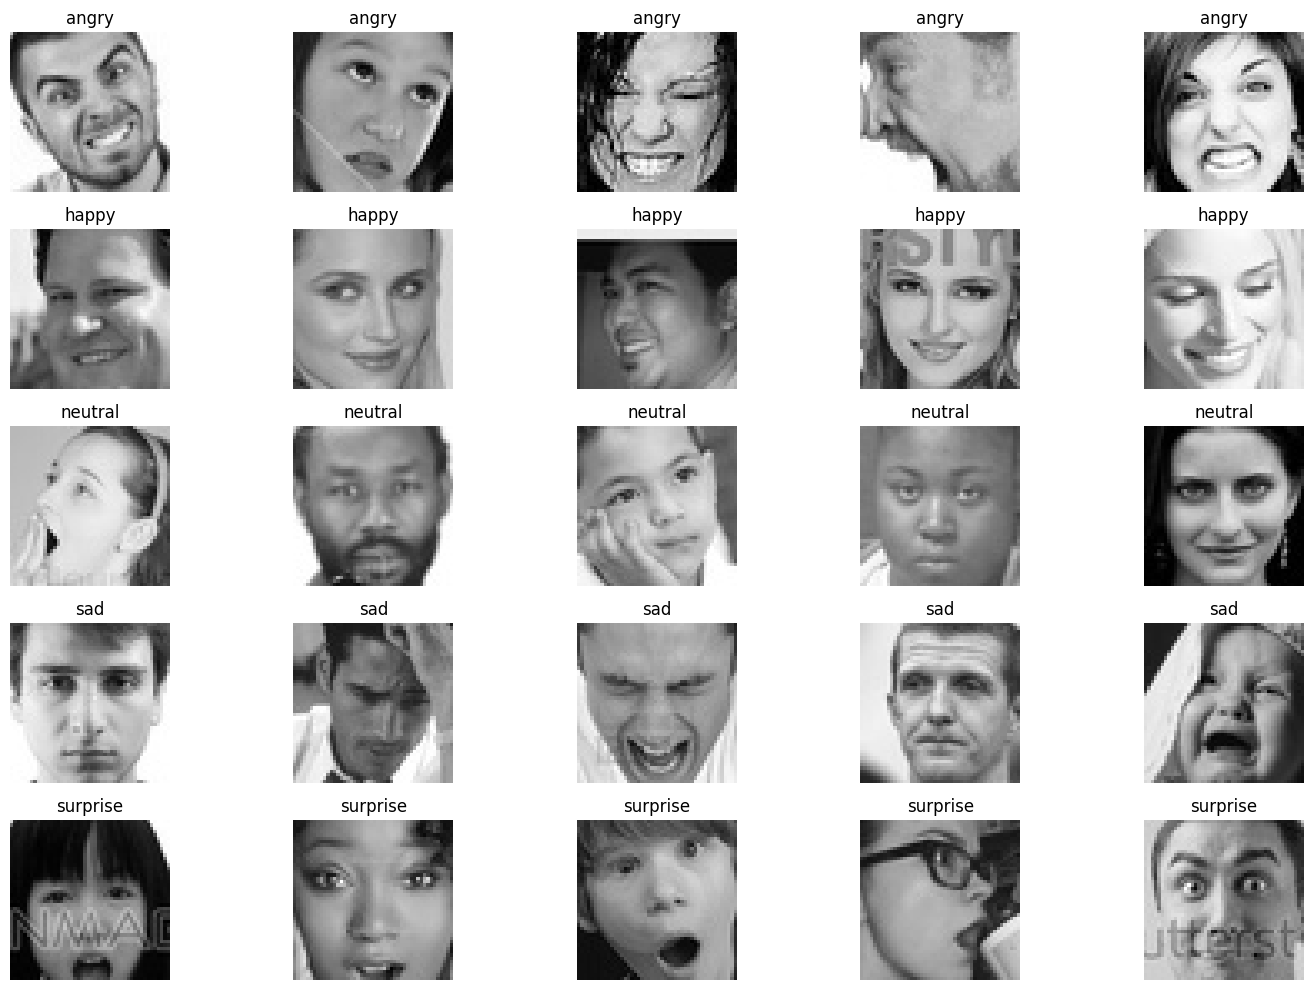

In [ ]:
import random

def show_sample_images(train_dir, class_names, image_size=(48, 48), samples_per_class=5):
    plt.figure(figsize=(15, len(class_names)*2))
    for i, class_name in enumerate(class_names):
        image_folder = os.path.join(train_dir, class_name)
        images = random.sample(os.listdir(image_folder), samples_per_class)
        for j, image_name in enumerate(images):
            img_path = os.path.join(image_folder, image_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)
            plt.subplot(len(class_names), samples_per_class, i*samples_per_class + j + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"{class_name}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_images(train_path, target_classes)


In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

This line of code normalizes the pixel values of the training and testing datasets (X_train and X_test) by scaling them to a range of [0, 1] by dividing each pixel value by 255 (since pixel values range from 0 to 255). This is a common preprocessing step to help neural networks converge more efficiently during training.

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

This code encodes the categorical labels (y_train and y_test) into numerical values using LabelEncoder, transforming the training labels into integers and applying the same transformation to the test labels.

In [ ]:
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

This code converts the encoded integer labels (y_train_encoded and y_test_encoded) into one-hot encoded vectors, which are suitable for multi-class classification in neural networks.

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0)}


This code calculates the class weights to handle class imbalance, ensuring that each class contributes equally to the model's training by assigning higher weights to underrepresented classes.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

This code initializes an image data generator with various augmentations (rotation, shifting, shear, zoom, flip) to artificially expand the dataset and improve model robustness by introducing variations in the training images.

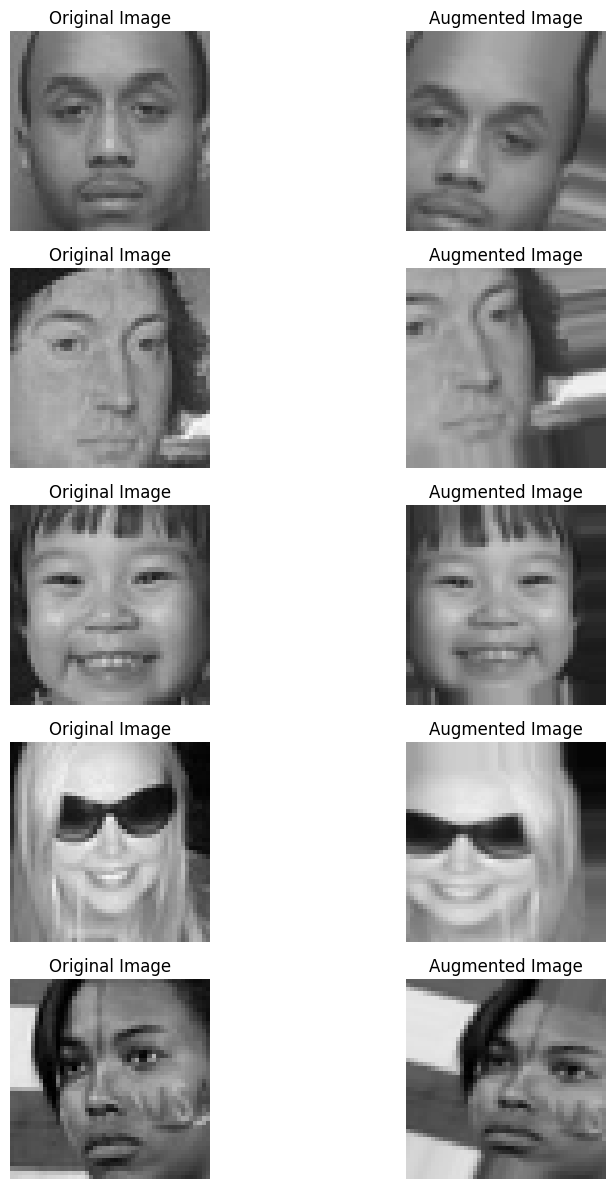

In [ ]:
num_samples = 5
random_indices = np.random.choice(len(X_train), num_samples, replace=False)
sample_images = X_train[random_indices]

sample_images = (sample_images * 255).astype("uint8")

augmented_images = []
for img in sample_images:
    img = img.reshape((1,) + img.shape)
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images).astype("uint8")

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 12))

for i in range(num_samples):
    axes[i, 0].imshow(sample_images[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(augmented_images[i])
    axes[i, 1].set_title("Augmented Image")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

This code randomly selects 5 images from the training set, applies data augmentation to each image using datagen, and displays the original and augmented images side by side for comparison.

## CNN + Transformer + EfficientNet Hybrid Model

In [ ]:
def cnn_trans_net (input_shape, num_classes):
    inputs = Input(shape=input_shape)

    effnet = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet', pooling='avg')
    for layer in effnet.layers:
        layer.trainable = False
    effnet_features = Lambda(lambda x: x * 0)(effnet.output)

    transformer_input = Flatten()(inputs)
    transformer_input_expanded = Lambda(lambda x: K.expand_dims(x, axis=1))(transformer_input)
    attn_output = MultiHeadAttention(num_heads=2, key_dim=32)(transformer_input_expanded, transformer_input_expanded)
    attn_output = LayerNormalization()(attn_output)
    attn_output = Lambda(lambda x: x[:, 0, :] * 0)(attn_output)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    merged = Concatenate()([x, effnet_features, attn_output])
    output = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=inputs, outputs=output)
    return model


This function defines a hybrid CNN model combining EfficientNet for feature extraction, a Transformer block for attention, and traditional convolutional layers to classify images into multiple classes, with dropout for regularization.

In [ ]:
cnn_trans_net = cnn_trans_net(input_shape=(48, 48, 3), num_classes=len(target_classes))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


This line creates a CNN model with an input shape of 48x48 pixels and 3 color channels, outputting predictions for a number of classes equal to the length of target_classes.


In [ ]:
cnn_trans_net.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
cnn_trans_net.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 48, 48, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 48, 48, 3) │          7 │ rescaling[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 48, 48, 3) │          0 │ normalization[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 49, 49, 3) │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 24, 24,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 24, 24,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 24, 24,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 24, 24,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 24, 24,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 24, 24,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 24, 24,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 24, 24,    │        512 │ block1a_se_excit

 Total params: 6,564,776 (25.04 MB)

 Trainable params: 2,515,205 (9.59 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

This line compiles the model using the Adam optimizer with a learning rate of  categorical crossentropy loss for multi-class classification, and accuracy as the evaluation metric.








In [ ]:
history = cnn_trans_net.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    epochs=80,
    validation_data=(X_test, y_test_cat),
    steps_per_epoch=len(X_train) // 32,)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


312/312 ━━━━━━━━━━━━━━━━━━━━ 65s 115ms/step - accuracy: 0.2017 - loss: 1.6091 - val_accuracy: 0.2065 - val_loss: 1.6035
Epoch 2/80
  1/312 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2188 - loss: 1.6122

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 1.6122 - val_accuracy: 0.2070 - val_loss: 1.6035
Epoch 3/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.2243 - loss: 1.6042 - val_accuracy: 0.2710 - val_loss: 1.5838
Epoch 4/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1562 - loss: 1.6084 - val_accuracy: 0.2770 - val_loss: 1.5835
Epoch 5/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2537 - loss: 1.5879 - val_accuracy: 0.3105 - val_loss: 1.5564
Epoch 6/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1875 - loss: 1.6116 - val_accuracy: 0.3070 - val_loss: 1.5578
Epoch 7/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2653 - loss: 1.5710 - val_accuracy: 0.3095 - val_loss: 1.5306
Epoch 8/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 1.5772 - val_accuracy: 0.3130 - val_loss: 1.5295
Epoch 9/80
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2825 - loss: 1.5577 - val_accuracy: 0.3410 -

This code trains the model using augmented images generated by datagen.flow() with a batch size of 32, for 80 epochs, with validation on the test set (X_test, y_test_cat), and sets the number of steps per epoch based on the training data size divided by the batch size.

## Classification Report

In [ ]:
y_pred_probs = cnn_trans_net.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print(" Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=target_classes))


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step
 Classification Report:

              precision    recall  f1-score   support

       angry       0.45      0.39      0.42       400
       happy       0.64      0.61      0.62       400
     neutral       0.45      0.49      0.47       400
         sad       0.53      0.28      0.37       400
    surprise       0.55      0.84      0.67       400

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.52      0.52      0.51      2000



This code evaluates the model's performance by predicting test labels and generating a detailed classification report (precision, recall, F1-score) for each emotion class.

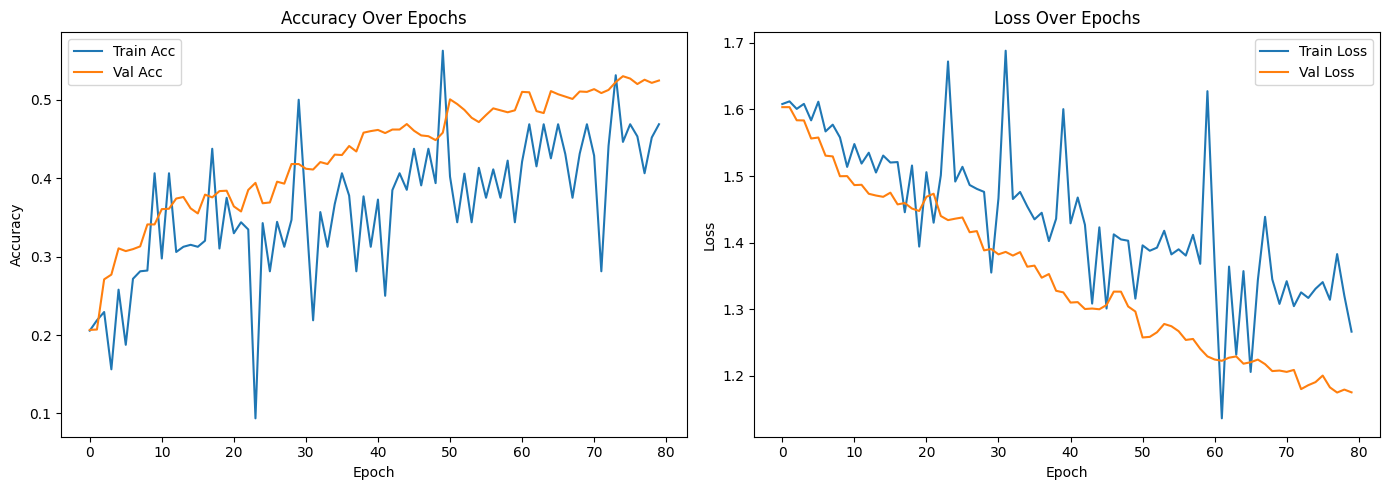

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

This code visualizes the model's training and validation accuracy and loss over epochs to assess performance trends and detect overfitting or underfitting.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


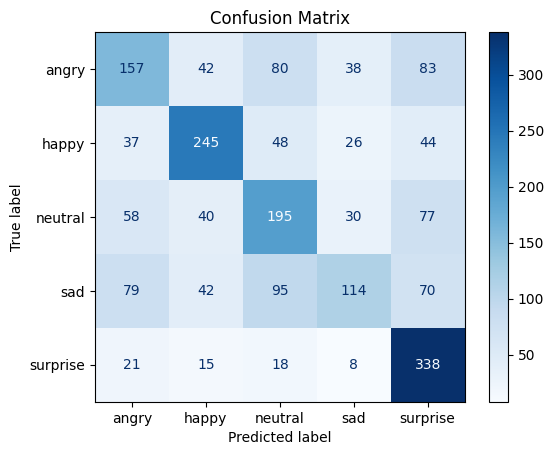

In [ ]:
y_pred = cnn_trans_net.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(y_test_encoded, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

This code generates and displays a confusion matrix to visually evaluate the model’s classification performance by comparing predicted and true labels.

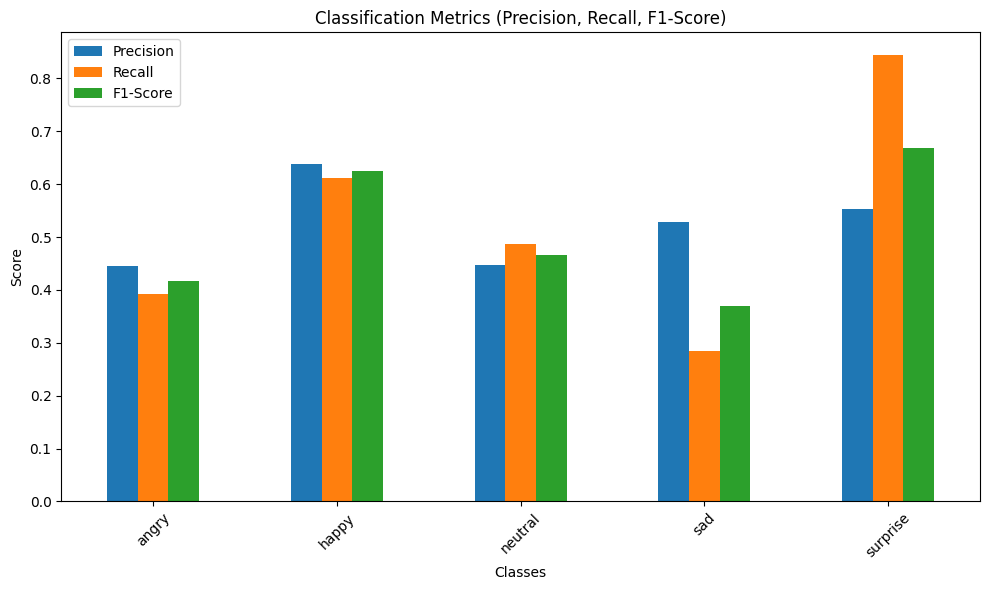

In [ ]:
report = classification_report(y_true, y_pred_classes, target_names=target_classes, output_dict=True)

precision = [report[class_name]['precision'] for class_name in target_classes]
recall = [report[class_name]['recall'] for class_name in target_classes]
f1_score = [report[class_name]['f1-score'] for class_name in target_classes]

metrics = np.array([precision, recall, f1_score]).T
metrics_df = pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1-Score'], index=target_classes)

metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Classification Metrics (Precision, Recall, F1-Score)')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This code calculates precision, recall, and F1-score for each class and plots them in a grouped bar chart to clearly visualize the model’s performance across different categories.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


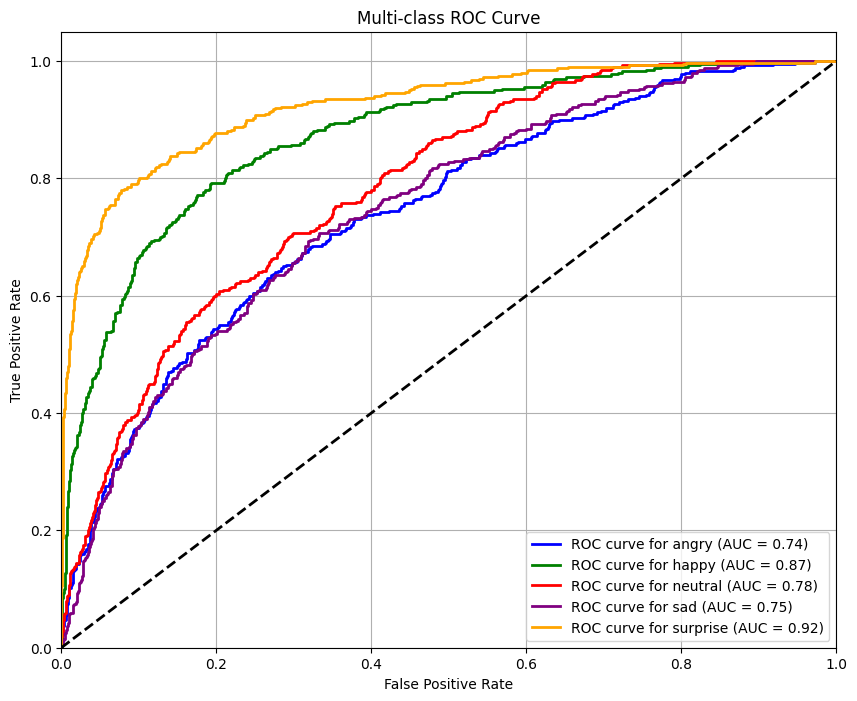

In [ ]:

y_pred_prob = cnn_trans_net.predict(X_test)
num_classes = y_test_cat.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'purple', 'orange']
class_names = label_encoder.classes_
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


This code calculates and plots the multi-class ROC curves with AUC scores for each class, helping visually assess the model’s ability to distinguish between different classes.

This code computes and plots the ROC curve for multi-class emotion classification, where each class (emotion) is evaluated separately with its corresponding AUC score, allowing for visualization of the model's performance across different classes.

## Facenet_CNN Model

In [ ]:
from tensorflow.keras import layers, Model

class L2Normalize(layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super(L2Normalize, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

def build_facenet_model(input_shape=(48, 48, 3), num_classes=5, embedding_dim=128):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    embedding = layers.Dense(embedding_dim)(x)
    embedding = L2Normalize(axis=-1)(embedding)


    outputs = layers.Dense(num_classes, activation='softmax')(embedding)

    model = Model(inputs, outputs)
    return model

facenet = build_facenet_model(input_shape=(48, 48, 3), num_classes=5)
facenet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

facenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalize (L2Normalize)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,501 (2.18 MB)

 Trainable params: 569,605 (2.17 MB)

 Non-trainable params: 896 (3.50 KB)

This code defines a FaceNet-style deep learning model for emotion classification, where the model includes convolutional layers for feature extraction, a dense layer for embedding generation, and L2 normalization to ensure the embeddings are unit vectors, followed by a final softmax layer for classification into 5 emotion categories.

In [ ]:
history = facenet.fit(
    datagen.flow(X_train, y_train_cat, batch_size=64),
    validation_data=(X_test, y_test_cat),
    epochs=50,

)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.2593 - loss: 1.5815 - val_accuracy: 0.2180 - val_loss: 1.6366
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.2953 - loss: 1.5516 - val_accuracy: 0.2000 - val_loss: 1.7666
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.3707 - loss: 1.4477 - val_accuracy: 0.2200 - val_loss: 1.6908
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.4238 - loss: 1.3618 - val_accuracy: 0.2275 - val_loss: 1.6539
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.4647 - loss: 1.2948 - val_accuracy: 0.3880 - val_loss: 1.4460
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.4843 - loss: 1.2480 - val_accuracy: 0.4145 - val_loss: 1.3772
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5013 - loss: 1.2086 - val_accuracy: 0.3745 - val_loss: 1.4814
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5361 - loss: 1.1579 - val_accuracy: 0.4

## Classification Report

In [ ]:
y_pred_probs = facenet.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_classes))

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Classification Report:

              precision    recall  f1-score   support

       angry       0.57      0.66      0.61       400
       happy       0.81      0.72      0.76       400
     neutral       0.59      0.59      0.59       400
         sad       0.55      0.44      0.49       400
    surprise       0.76      0.86      0.81       400

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



This code generates predictions from the model, compares them to the true labels, and prints a classification report showing precision, recall, and F1-score for each target class.

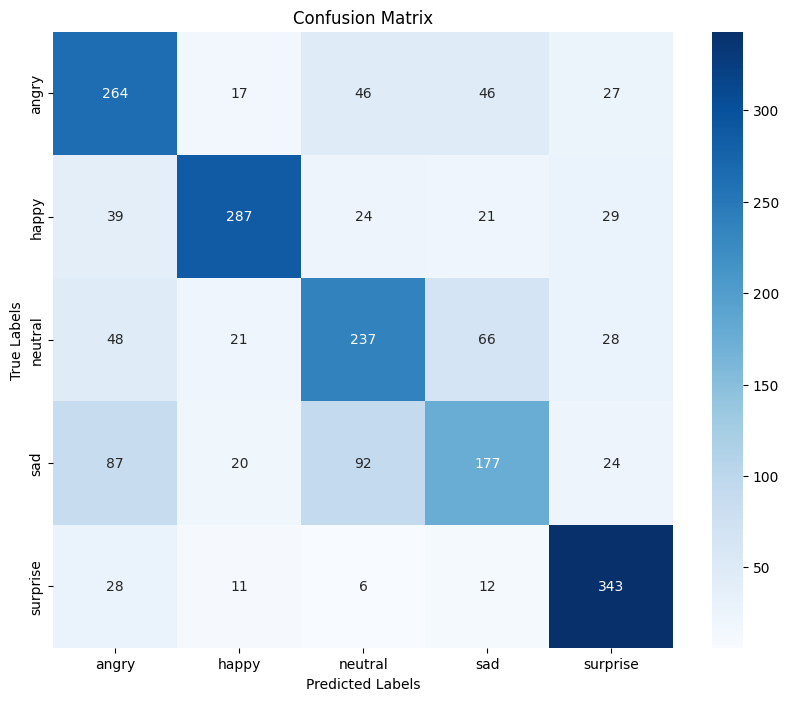

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_classes,
            yticklabels=target_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


This code generates a confusion matrix by comparing the predicted labels (y_pred) with the true labels (y_true) and visualizes it as a heatmap, displaying the count of correct and incorrect predictions for each class in a clear and color-coded format.

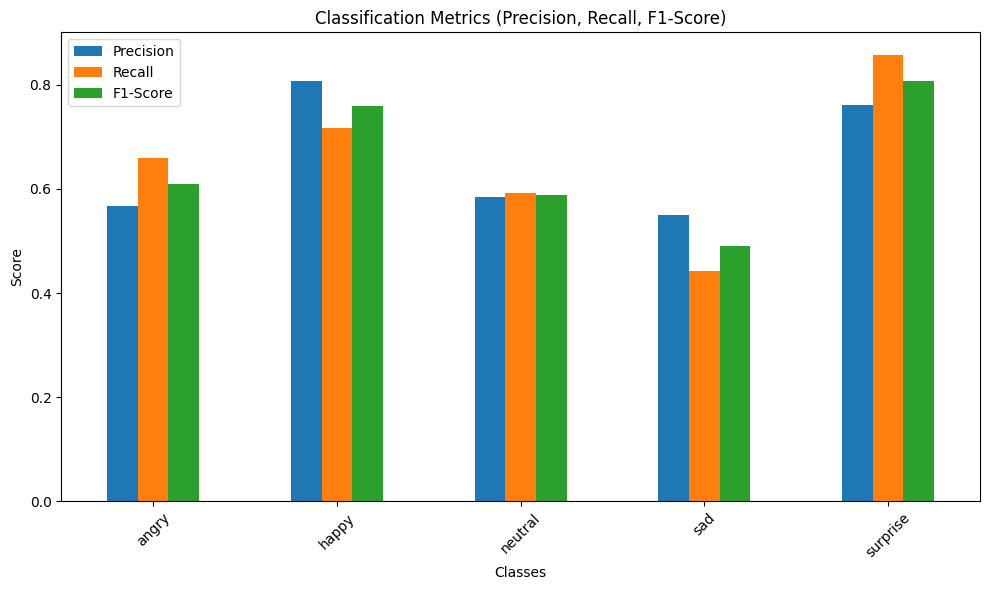

In [ ]:

report = classification_report(y_true, y_pred, target_names=target_classes, output_dict=True)

precision = [report[class_name]['precision'] for class_name in target_classes]
recall = [report[class_name]['recall'] for class_name in target_classes]
f1_score = [report[class_name]['f1-score'] for class_name in target_classes]

metrics = np.array([precision, recall, f1_score]).T
metrics_df = pd.DataFrame(metrics, columns=['Precision', 'Recall', 'F1-Score'], index=target_classes)

metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Classification Metrics (Precision, Recall, F1-Score)')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


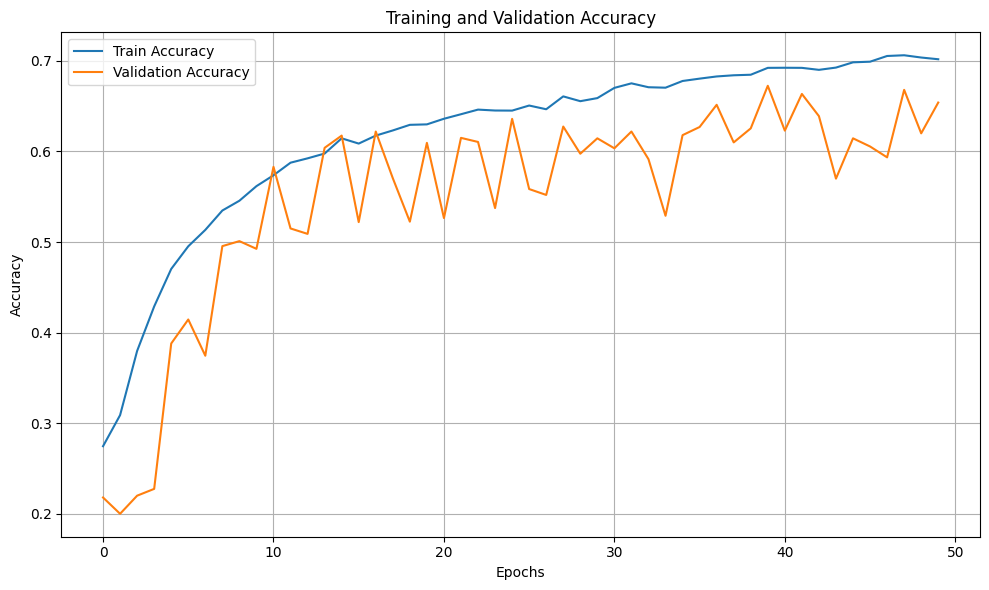

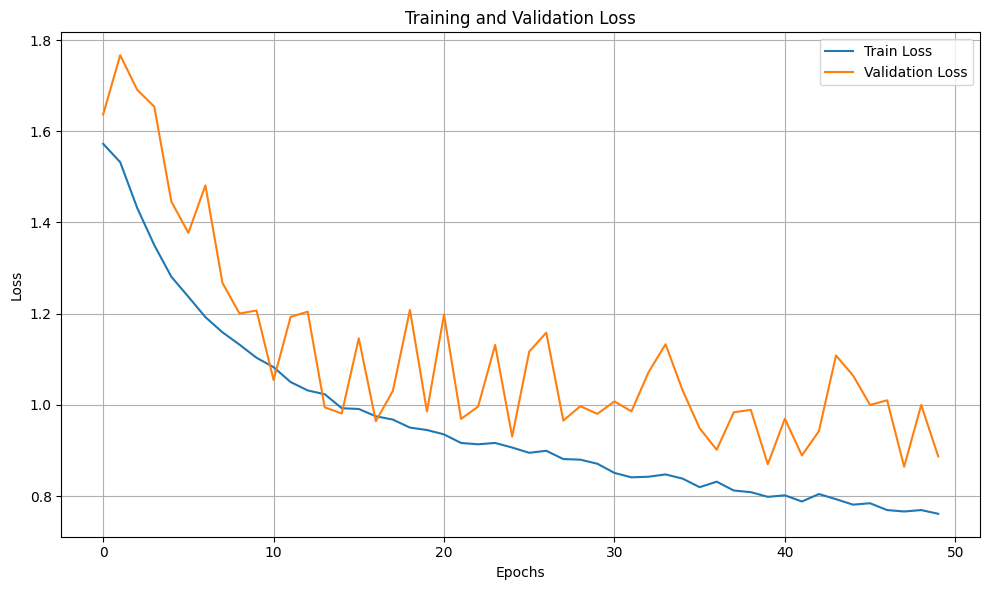

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This code extracts precision, recall, and F1-score from the classification report for each class and plots them as a bar graph for easy comparison across different classes.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


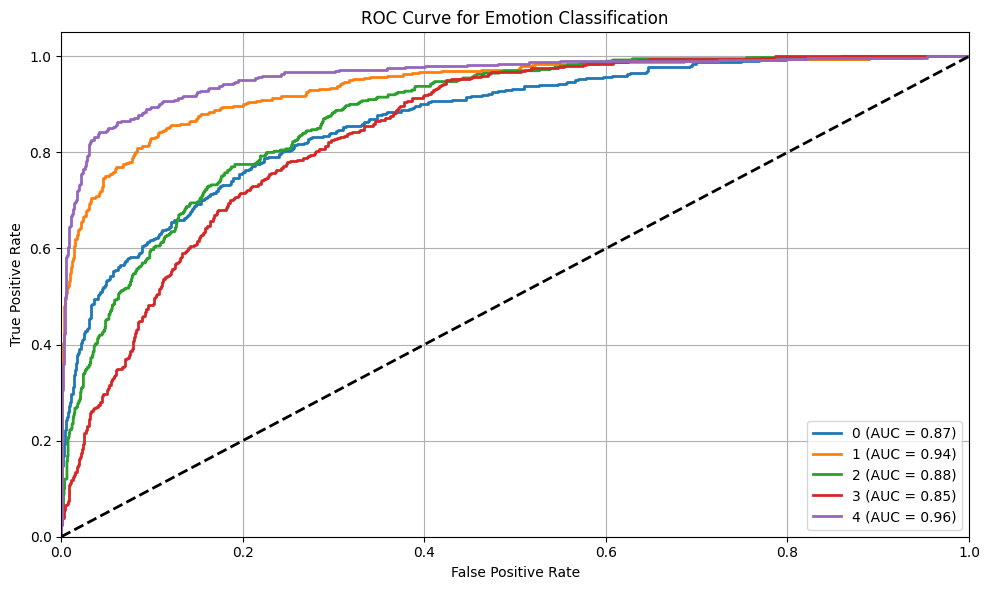

In [ ]:
y_true = y_test_cat
y_pred = facenet.predict(X_test)

lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_true_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))

for i in range(y_true_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Emotion Classification')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()


This code calculates and plots the ROC curve for each class in a multi-class classification problem, displaying the True Positive Rate against the False Positive Rate and calculating the AUC (Area Under Curve) for each class.

This code compares class-wise Precision, Recall, and F1-Score for three emotion recognition models and visualizes them in grouped bar charts for each metric across five emotion classes.

## CNN + Transformer Model with finetunning (proposed model)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_cnn_transformer_model():
    inputs = tf.keras.Input(shape=(48, 48, 3))

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)  # 24x24

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)  # 12x12

    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Reshape((36, 256))(x)

    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    ffn_output = layers.Dense(512, activation='relu')(x)
    ffn_output = layers.Dense(256)(ffn_output)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

cnn_trans = build_cnn_transformer_model()
cnn_trans.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 48, 48,    │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 48, 48,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 24, 24,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 24, 24,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 24, 24,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 12, 12,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 12, 12,    │    295,168 │ max_pooling2d_10… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 12, 12,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 6, 6, 256) │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 36, 256)   │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 36, 256)   │    263,168 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 36, 256)   │          0 │ reshape_1[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 36, 256)   │        512 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 1,872,197 (7.14 MB)

 Trainable params: 1,871,301 (7.14 MB)

 Non-trainable params: 896 (3.50 KB)

This code defines a hybrid CNN-Transformer model that extracts spatial features using convolutional layers and enhances global feature learning using Multi-Head Attention, followed by dense layers for 5-class classification on 48×48×3 images.

In [ ]:
cnn_trans.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
history= cnn_trans.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    epochs=80,
    validation_data=(X_test, y_test_cat))

Epoch 1/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5408 - loss: 1.1445 - val_accuracy: 0.5570 - val_loss: 1.0821
Epoch 2/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5585 - loss: 1.0876 - val_accuracy: 0.5800 - val_loss: 1.0621
Epoch 3/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5654 - loss: 1.0983 - val_accuracy: 0.5720 - val_loss: 1.0659
Epoch 4/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5577 - loss: 1.0964 - val_accuracy: 0.5880 - val_loss: 1.0491
Epoch 5/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5651 - loss: 1.0864 - val_accuracy: 0.5695 - val_loss: 1.0753
Epoch 6/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5766 - loss: 1.0644 - val_accuracy: 0.5945 - val_loss: 1.0062
Epoch 7/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5696 - loss: 1.0773 - val_accuracy: 0.5950 - val_loss: 1.0199
Epoch 8/80
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5567 - loss: 1.0944 - val_accu

## Parameter Finetunning

In [ ]:
for layer in cnn_trans.layers[:10]:
    layer.trainable = False

for layer in cnn_trans.layers[10:]:
    layer.trainable = True

This code freezes the first 10 layers of the cnn_trans model (to retain pre-learned features) and unfreezes the rest for fine-tuning, allowing selective training of deeper layers for better performance on new data.

This line compiles the cnn_trans model using the Adam optimizer with a very low learning rate (1e-5), categorical cross-entropy loss for multi-class classification, and tracks accuracy as the evaluation metric.


In [ ]:
fine_tune_history = cnn_trans.fit(datagen.flow(X_train, y_train_cat, batch_size=32), validation_data=(X_test, y_test_cat), epochs=50)

Epoch 1/50
  1/313 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.8125 - loss: 0.6421

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6886 - loss: 0.8102 - val_accuracy: 0.6765 - val_loss: 0.8332
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6826 - loss: 0.8099 - val_accuracy: 0.6700 - val_loss: 0.8410
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6889 - loss: 0.8093 - val_accuracy: 0.6660 - val_loss: 0.8675
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6912 - loss: 0.8090 - val_accuracy: 0.6735 - val_loss: 0.8423
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6942 - loss: 0.7908 - val_accuracy: 0.6700 - val_loss: 0.8546
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6896 - loss: 0.8140 - val_accuracy: 0.6795 - val_loss: 0.8507
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7001 - loss: 0.7966 - val_accuracy: 0.6785 - val_loss: 0.8396
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6855 - loss: 0.7933 - val_accuracy: 0.675

This code fine-tunes the CNN-Transformer model by training it for 30 epochs using augmented training data (via datagen) and evaluates performance on test data after each epoch.


## Classification Report

In [ ]:
y_pred_probs_ft = cnn_trans.predict(X_test)
y_pred_classes_ft = np.argmax(y_pred_probs_ft, axis=1)
y_true_ft = np.argmax(y_test_cat, axis=1)
print("Classification Report for Fine-Tuned Model:\n")
print(classification_report(y_true_ft, y_pred_classes_ft, target_names=target_classes))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report for Fine-Tuned Model:

              precision    recall  f1-score   support

       angry       0.63      0.64      0.63       400
       happy       0.75      0.79      0.77       400
     neutral       0.55      0.73      0.63       400
         sad       0.60      0.39      0.47       400
    surprise       0.85      0.81      0.83       400

    accuracy                           0.67      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.68      0.67      0.67      2000



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


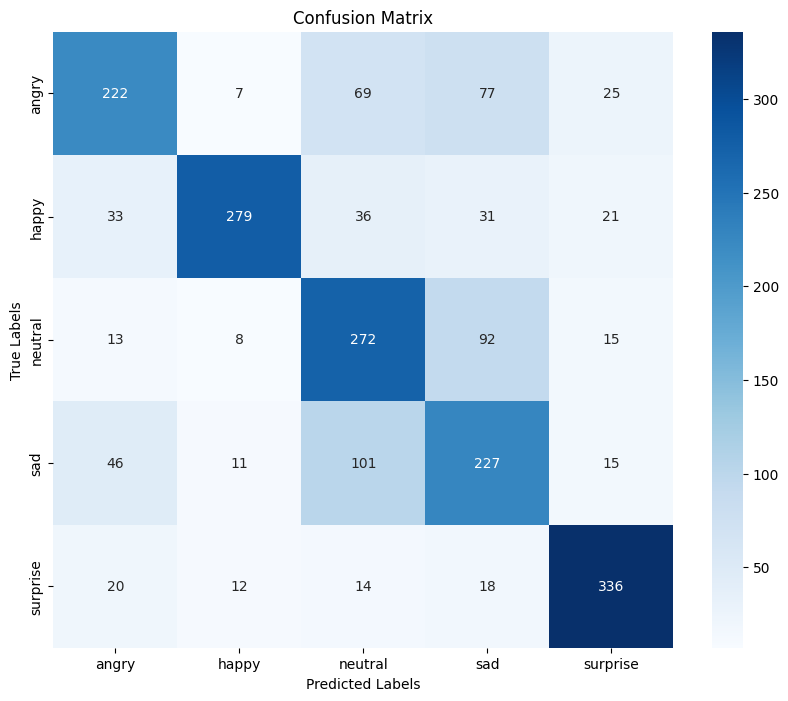

In [ ]:
y_pred = cnn_trans.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

target_classes = ['angry', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_classes,
            yticklabels=target_classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


This code visualizes the training and validation accuracy and loss over epochs to evaluate the model's performance and check for overfitting or underfitting.

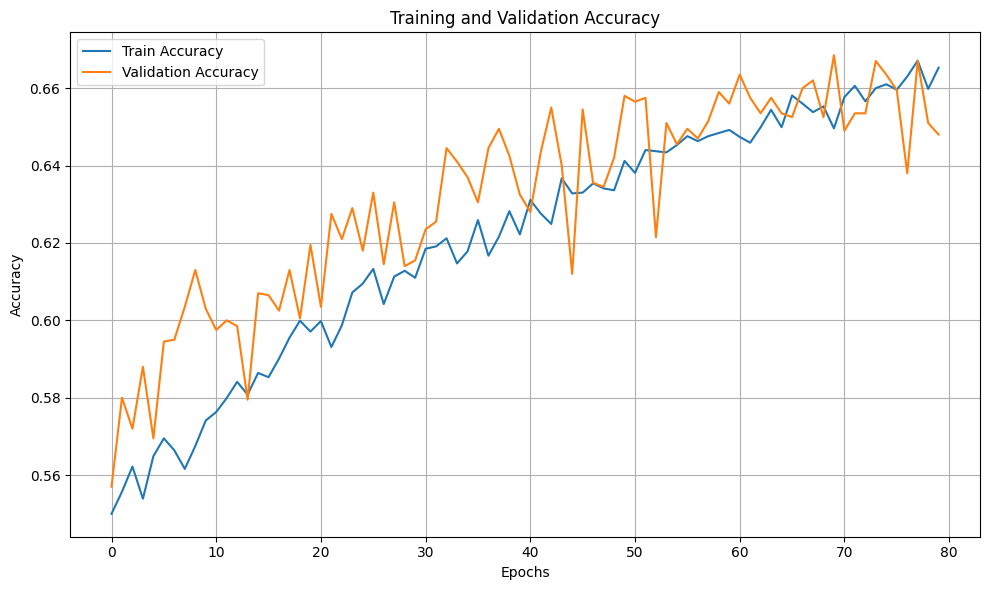

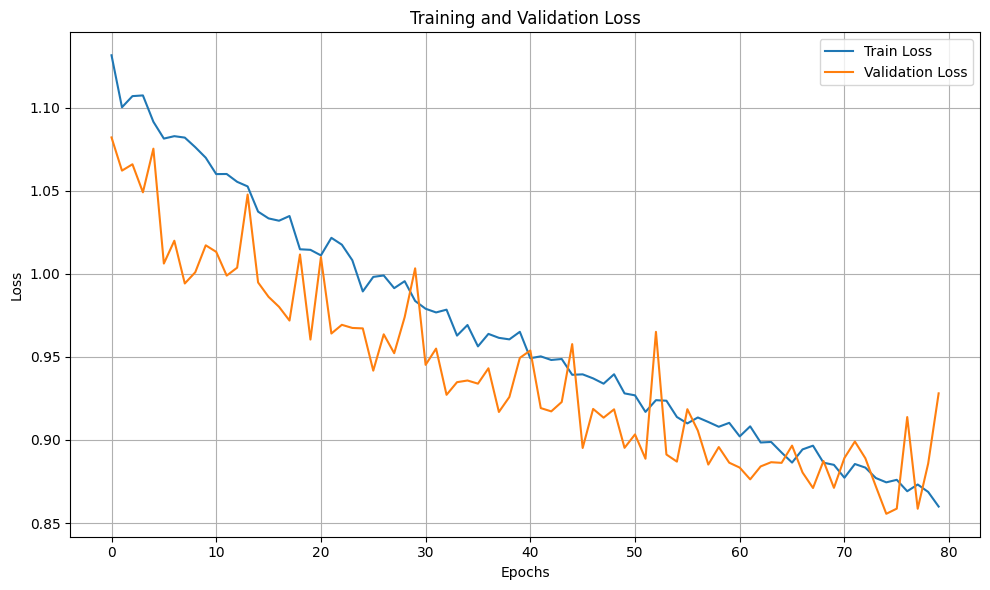

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This code computes and plots the multi-class ROC curves and AUC scores for each emotion class predicted by the CNN+Transformer model, showing its classification performance visually.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


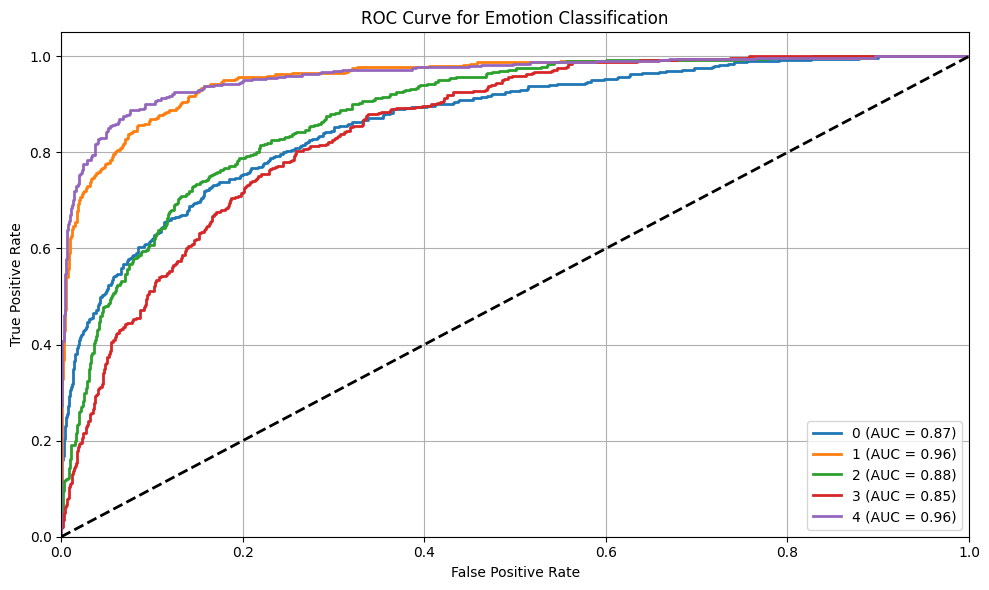

In [ ]:
y_true = y_test_cat
y_pred = cnn_trans.predict(X_test)

lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_true_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))

for i in range(y_true_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Emotion Classification')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()


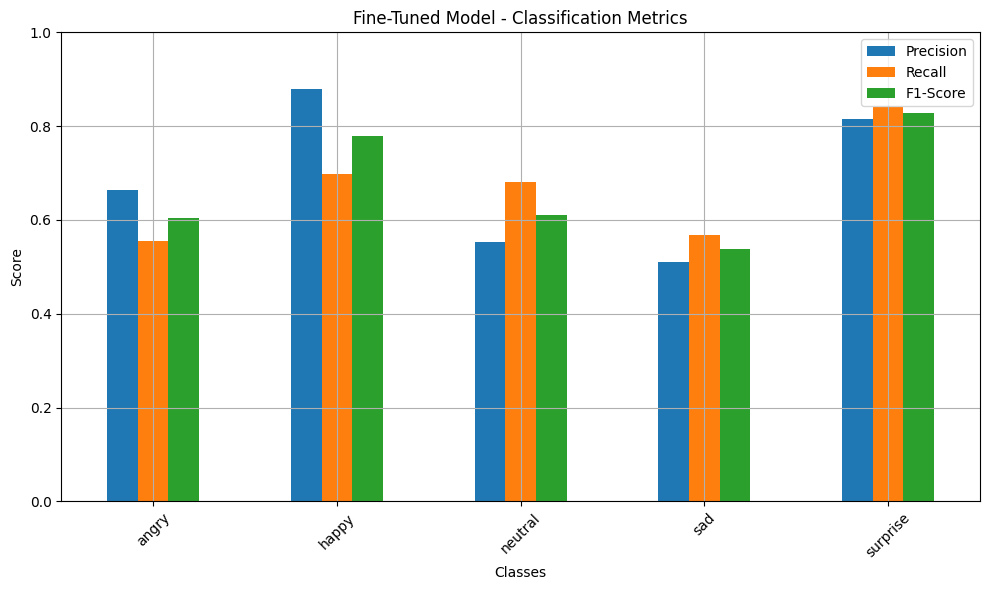

In [ ]:
report_ft = classification_report(y_true_ft, y_pred_classes_ft, target_names=target_classes, output_dict=True)

precision_ft = [report_ft[class_name]['precision'] for class_name in target_classes]
recall_ft = [report_ft[class_name]['recall'] for class_name in target_classes]
f1_score_ft = [report_ft[class_name]['f1-score'] for class_name in target_classes]

metrics_ft = pd.DataFrame({
    'Precision': precision_ft,
    'Recall': recall_ft,
    'F1-Score': f1_score_ft
}, index=target_classes)

metrics_ft.plot(kind='bar', figsize=(10, 6))
plt.title('Fine-Tuned Model - Classification Metrics')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


This code generates a bar chart showing the Precision, Recall, and F1-Score for each emotion class predicted by the fine-tuned model using values from the classification report, helping to visually assess class-wise performance.

## Comparative Graph

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


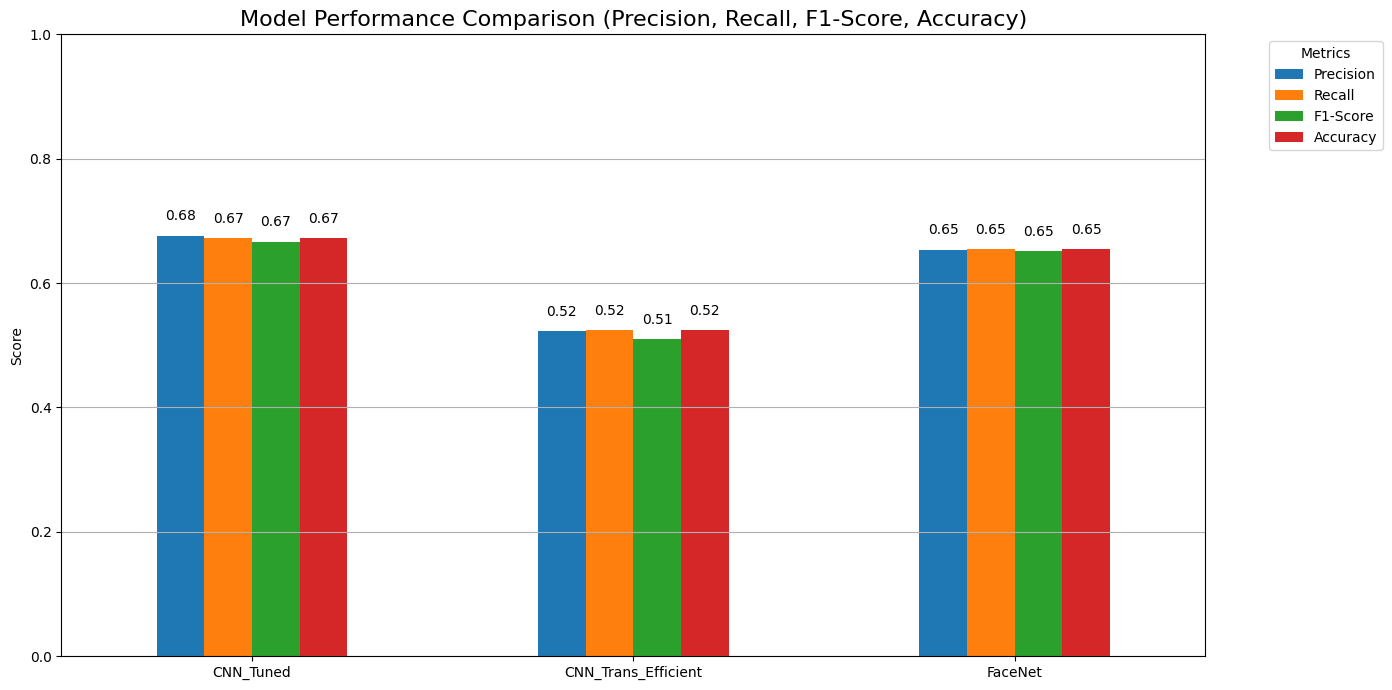

In [60]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define your models
models = {
    'CNN+Transformer(proposed)': cnn_trans,
    'CNN_Trans_net': cnn_trans_net,
    'FaceNet': facenet
}

metric_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
results = []

# Evaluate each model
for name, model in models.items():
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Use target_classes for classification report
    report = classification_report(y_true, y_pred, target_names=target_classes, output_dict=True)

    precision_avg = np.mean([report[c]['precision'] for c in target_classes])
    recall_avg = np.mean([report[c]['recall'] for c in target_classes])
    f1_avg = np.mean([report[c]['f1-score'] for c in target_classes])
    accuracy = accuracy_score(y_true, y_pred)

    results.append([precision_avg, recall_avg, f1_avg, accuracy])

# Create DataFrame with updated model names
results_df = pd.DataFrame(results, columns=metric_names, index=['CNN_Trans_Tuned', 'CNN_Trans_Efficient', 'FaceNet'])

# Plotting
ax = results_df.plot(kind='bar', figsize=(14, 7), rot=0)

plt.title('Model Performance Comparison (Precision, Recall, F1-Score, Accuracy)', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate bars
for i, patch in enumerate(ax.patches):
    height = patch.get_height()
    x_position = patch.get_x() + patch.get_width() / 2
    ax.text(x_position, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


This code is used to evaluate and compare the performance of three different models (CNN+Transformer, CNN_Transformer_Tuned, and FaceNet) based on several classification metrics (Precision, Recall, F1-Score, and Accuracy). It computes these metrics for each model, including a fine-tuned model, and then visualizes the results in a bar plo

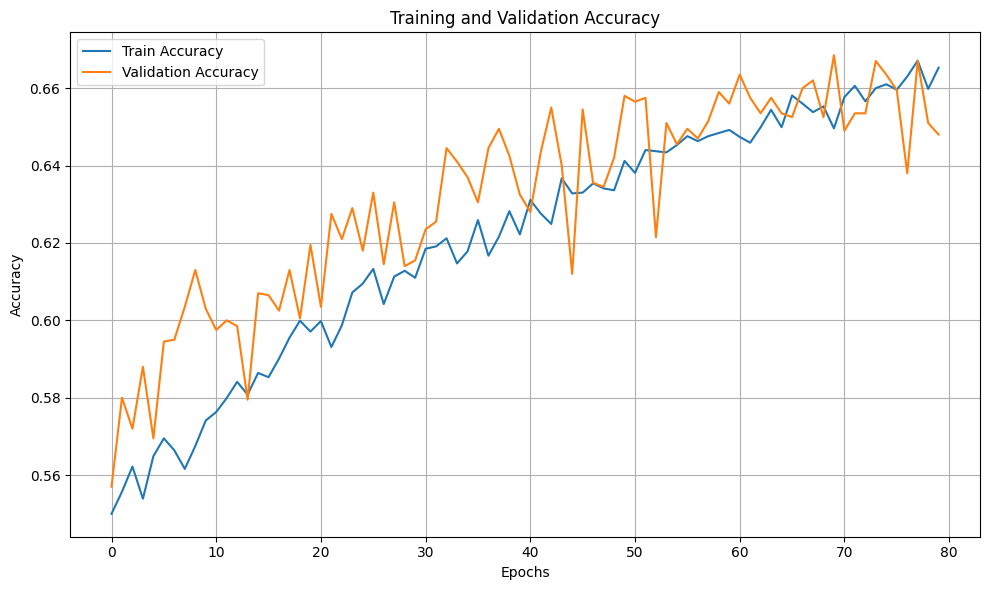

In [ ]:
# prompt: now i want to save the model and load the load model plot a graph frothe model

import matplotlib.pyplot as plt
# Save the model
cnn_trans.save('/content/drive/MyDrive/FER/cnn_trans_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/FER/cnn_trans_model.h5', compile=False) # Assuming you have the model saved in this path

# Compile the loaded model (essential for making predictions)
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# Now you can use the loaded_model for plotting a graph (example using the training history)

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy') # Use 'history' from the initial training
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Use 'history' from the initial training
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
